### <center> Cornell Birdcall Identification </center>

## 1. Business Problem:-
### 1.1 Description 

Do you hear the birds chirping outside your window? Over 10,000 bird species occur in the world, and they can be found in nearly every environment, from untouched rainforests to suburbs and even cities. Birds play an essential role in nature. They are high up in the food chain and integrate changes occurring at lower levels. As such, birds are excellent indicators of deteriorating habitat quality and environmental pollution. However, it is often easier to hear birds than see them. With proper sound detection and classification, researchers could automatically intuit factors about an area’s quality of life based on a changing bird population.

There are already many projects underway to extensively monitor birds by continuously recording natural soundscapes over long periods. However, as many living and nonliving things make noise, the analysis of these datasets is often done manually by domain experts. These analyses are painstakingly slow, and results are often incomplete. Data science may be able to assist, so researchers have turned to large crowdsourced databases of focal recordings of birds to train AI models. Unfortunately, there is a domain mismatch between the training data (short recording of individual birds) and the soundscape recordings (long recordings with often multiple species calling at the same time) used in monitoring applications. This is one of the reasons why the performance of the currently used AI models has been subpar.
<img src="https://storage.googleapis.com/kaggle-media/competitions/Birdsong/Bewick's%20Wren%20%C2%A9%20Derek%20Hameister%20_%20Macaulay%20Library%20at%20the%20Cornell%20Lab%20of%20Ornithology%20ML214764391.png" />

To unlock the full potential of these extensive and information-rich sound archives, researchers need good machine listeners to reliably extract as much information as possible to aid data-driven conservation.

The Cornell Lab of Ornithology’s Center for Conservation Bioacoustics (CCB)’s mission is to collect and interpret sounds in nature. The CCB develops innovative conservation technologies to inspire and inform the conservation of wildlife and habitats globally. By partnering with the data science community, the CCB hopes to further its mission and improve the accuracy of soundscape analyses.

In this case study, we will identify a wide variety of bird vocalizations in soundscape recordings. Due to the complexity of the recordings, they contain weak labels. There might be anthropogenic sounds (e.g., airplane overflights) or other bird and non-bird (e.g., chipmunk) calls in the background, with a particular labeled bird species in the foreground. we will try to bring new ideas to build effective detectors and classifiers for analyzing complex soundscape recordings!

CREDITS:- Kaggle

### 1.2 Problem Statement 
For each time window, we need to predict the bird species that made a call beginning or ending in that time window. If there are no bird calls in a time window, we will predict nocall.

### 2. Model-Prediction

In [71]:
# importing important libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import pickle
from sklearn.metrics import f1_score, accuracy_score
import tensorflow_addons as tfa
import librosa
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
from IPython.display import Audio
from pydub import AudioSegment
import pickle
import cv2
import logging
import os

# supressing unwanted tesorflow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
# loading the test data set
data,label = pickle.load(open('model_logs/test_data.pkl','rb'))
# checking some rows of data set
data.head(2)

,filename,filepath,duration,sampling_rate,ebird_code
20567,XC453756.mp3,train_audio/wooduc/XC453756.mp3,4,48000 (Hz),wooduc
8951,XC481153.mp3,train_audio/gocspa/XC481153.mp3,15,44100 (Hz),gocspa


In [3]:
label[label=='aldfly'].head(2)

59    aldfly
24    aldfly
Name: ebird_code, dtype: object

In [4]:
# Defining the parameters and setting seed values
seed = 45
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

NUM_CLASSES = 264 
# CLASSES = list(df_audio['ebird_code'].unique())
# TARGETS = np.eye(NUM_CLASSES)

class params:
    sr = 32000
#     sr = 22500
    duration = 5
    img_size = None

    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = 16000
    
    n_fft = n_mels * 20 # Size of fft window - smooths the spectrogram
    
    spec_width = 256
    hop_length = duration * sr // spec_width + 1   # Computed to have width=spec_width

In [5]:
# Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def normalize(image, mean=None, std=None):
    """
    Normalizes an array in [0, 255] to the format adapted to neural network
    Arguments:
        image {np array [3 x H x W]} -- [description]
    Keyword Arguments:
        mean {None or np array} -- Mean for normalization, expected of size 3 (default: {None})
        std {None or np array} -- Std for normalization, expected of size 3 (default: {None})
    Returns:
        np array [H x W x 3] -- Normalized array
    """
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return image.astype(np.float32) # np.moveaxis(image, 2, 0).astype(np.float32)


def crop_or_pad(y, length, sr, train=False, probs=None):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})
        probs {None or numpy array} -- Probabilities to use to chose where to crop (default: {None})
    Returns:
        1D np array -- Cropped array
    """
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if not train:
            start = 0
        elif probs is None:
            start = np.random.randint(len(y) - length)
        else:
            start = (
                np.random.choice(np.arange(len(probs)), p=probs) + np.random.random()
            )
            start = int(sr * (start))

        y = y[start : start + length]

    return y.astype(np.float32)

In [6]:
# http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.melspectrogram.html

def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(y, sr=params.sr, n_mels=params.n_mels, hop_length=params.hop_length,
                                             fmin=params.fmin, fmax=params.fmax)
    melspec = librosa.power_to_db(melspec).astype(np.float32)
    
    return melspec


def compute_spectrogram(y, params):
    """
    Computes a spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    X = np.abs(librosa.stft(y, n_fft=1024, hop_length=params.hop_length))
    spect = librosa.amplitude_to_db(X).astype(np.float32)

    return spect

In [7]:
# Referred from the AppliedAI Assignments

class MelSpecDataset:
    """
    Tensor dataset
    """

    def __init__(self, df, params, train=False):
        """
        Constructor
        Arguments:
            df {pandas dataframe} -- Metadata
            params {AudioParams} -- Audio parameters
        Keyword Arguments:
            train {bool} -- Whether the dataset is used for training or validation (default: {True})
            use_conf {bool} -- Whether to use confidence for cropping (default: {False})
        """
        self.train = train
        self.params = params
        self.paths = df["filepath"].values
        self.sample_len = params.duration * params.sr
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
#         y, sr = soundfile.read(self.paths[idx])
        try:
            samples, sample_rate = librosa.load(self.paths[idx],sr=self.params.sr)
        except:
            sound = AudioSegment.from_file(self.paths[idx])
            samples = sound.get_array_of_samples()
            new_sound = sound._spawn(samples)
            samples = np.array(samples).astype(np.float32)
        

        samples = crop_or_pad(samples, self.sample_len, sr=self.params.sr, train=self.train, probs=None)
        melspec = compute_melspec(samples, self.params)
#         melspec = compute_spectrogram(samples, self.params)

        image = mono_to_color(melspec)
        image = normalize(image, mean=None, std=None)
        image = cv2.resize(image, (224, 224))
#         image = cv2.resize(image, (299, 299))

        return image


class Dataloader(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        data = np.asarray(data)
        
        return data # tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [8]:
def Prediction(dataset):
    """
    Function to make prediction for the feature vector/vectors
    Argument: Series of filepaths
    Returns tuple of predicted class probabilities, predicted class and preedicted bird species
    """
    
    # processing the feature vector
    d = MelSpecDataset(data,params)
    image = Dataloader(d,batch_size=len(dataset))[0]
    
    # Loading the Best models
#     best_model = load_model('model_logs/model_vgg2.h5')
    best_model = load_model('model_logs/res_vgg.h5')
    
    # making predictions
#     y_predicted = best_model.predict(image)
    y_predicted = best_model.predict([image,image])
    
    bird_species_mapping, ebird_code_labeled, ebird_code_classes = pickle.load(open('model_logs/bird_species_code.pkl','rb'))
    y_pred = []
    pred_bird = []
    for p in np.greater(y_predicted,0.004).astype(int):
        y_pr = np.nonzero(p)
        predicted_bird = ' '.join([ebird_code_classes[i] for i in y_pr[0]])
        y_pred.append(y_pr)
        pred_bird.append(predicted_bird)
        
        
#     y_pred = np.argmax(y_predicted,axis=1)
#     pred_bird = ' '.join([ebird_code_classes[i] for i in y_pred])
    
    return y_predicted,y_pred,pred_bird

In [240]:
def Evaluate(X,y):
    """
    Function to evaluate the performance of the models
    Argument: Series of filepaths and labels
    Returns tuple of performance measeure and dataframe of good and bad prediction(s)
    """
    
    # proper labeling of the classes
    y = y.apply(lambda x : ebird_code_labeled[x])
    
    # making predictions
    y_prob,y_pred,_ = Prediction(X)
    
    
    # computing performance metric
#     score =  f1_score(y,y_pred,average='macro')
#     loss = tf.keras.losses.sparse_categorical_crossentropy
    loss = tf.keras.losses.BinaryCrossentropy()
    pred_type = []
    losses = []
    score = 0
    
    for i in range(len(y_pred)):
        y_true = np.zeros((1,264))
        y_true[:,y.values[i]] = 1
        
        score += f1_score(y_true,y_pred[i],average='macro')
        l = loss(y.values[i],y_prob[i])
        
        if l > 0.5:
            pred_type.append('bad')
        else:
            pred_type.append('good')
            
        losses.append(l.numpy())
       
    score /= len(y)
    binning = pd.DataFrame({'pred_class':y_pred, 'loss':losses, 'type':pred_type})
    
    return score,binning

In [55]:
# let us do some prediction
%%time
bird_species_mapping, _ , _ = pickle.load(open('model_logs/bird_species_code.pkl','rb'))
bird = Prediction(data.iloc[100:101])[2]
print("The predicted bird is: ",.bird)

The predicted bird is:  btnwar
CPU times: user 3.85 s, sys: 788 ms, total: 4.64 s
Wall time: 2.27 s


In [60]:
%%time
print("The predicted bird is: ",Prediction(data.iloc[:5])[2])

The predicted bird is:  wooduc amecro canwre fiscro plsvir
CPU times: user 16.9 s, sys: 3.48 s, total: 20.3 s
Wall time: 10.5 s


In [70]:
%%time
sc, bin_df = Evaluate(data.iloc[:10],label.iloc[:10])
print("The score is: ",sc)

The score is:  0.8046
CPU times: user 37.6 s, sys: 5.2 s, total: 42.8 s
Wall time: 31.4 s


In [69]:
%%time
sc1, bin_df1 = Evaluate(data.iloc[10:50],label.iloc[10:50])
print("The score is: ",sc1)

The score is:  0.7824
CPU times: user 2min 33s, sys: 22.9 s, total: 2min 56s
Wall time: 2min 9s


Text(0.5, 0, 'Predicted class (Good if loss is below threshold)')

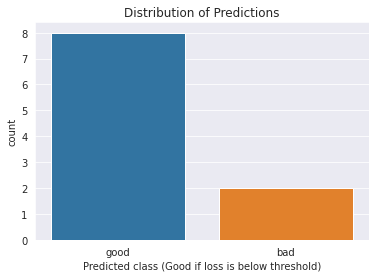

In [73]:
import seaborn as sns
sns.set_style('darkgrid')
ax = sns.countplot(x="type1", data=bin_df)
ax.set_title("Distribution of Predictions")
ax.set_xlabel("Predicted class (Good if loss is below threshold)")

Text(0.5, 0, 'Predicted class (Good if loss is below threshold)')

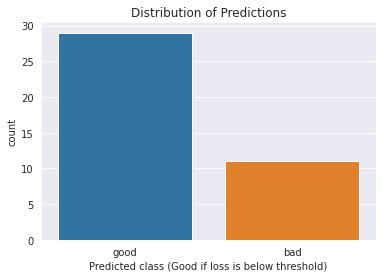

In [77]:
ax = sns.countplot(x="type1", data=bin_df3)
ax.set_title("Distribution of Predictions")
ax.set_xlabel("Predicted class (Good if loss is below threshold)")

### 3. Summary:-
Here, I created two main functions namely Prediction and Evaluate to make predictions on the incoming data and evaluate the model as the name suggests. I tried to create to pipeline which takes audio file as input process it and predict the call of the bird in that audio. The second function is used to evaluate the performance of the model and anlyze the good and bad predictions based on the predictions bin it generate. To generate the prediction bins we used the invidual loss function for the prediction and set a threshold, if the loss for that prediction is greater than the threshold we bin it as bad prediction while if it is in the limit we consider it as a good prediction. We use the loss we obtained while evaluation of our best model on the validation data set plus some small epsilon value to avoid the false positives as threshold value here.

The above two plotted distributions shows the distribution of good and bad predictions we got when we evaluated our best model for some data. In first distribution, we observe quite well number of good predictions around 80% given we chose around 10 samples of data. In second distribution, we tried to evaluate on more samples of data and found that model is still doing well with around 79% of good predictions.

While making the predictions and evaluations we calculated the running time to observe that running time of the model and observed that model is quite fast and providing output for single data sample within seconds.